# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

Tecnológico de Monterrey
Prof Luis Eduardo Falcón Morales

### **Adtividad de Semana 3**

### **Regresión Logística y problemas de crédito**

### **Los temas a estudiar en esta actividad son:**

*   **modelo de Regresión Logística**
*   **modelo de kNN**
*   **Métricas de clasificación y matriz de confusión**
*   **Uso de Pipeline para encapsular transformaciones**
*   **Ajuste de hiperparámetros con búsqueda de malla (GridSearch)**

# **Caso aprobación de tarjetas de créditos Australianos**

La asignación o rechazo a la solicitud de un crédito financiero o de una tarjeta de crédito, es uno de los problemas más estudiados por instituciones financieras por su relevancia y gran complejidad. Existe una gran cantidad de artículos de investigación al respecto.

Debido a lo delicado de la información que ahí se analiza no es fácil encontrar bases de datos abiertas con las cuales practicar. Sin embargo, en particular el conjunto de datos conocido como "Australian credit approval" es una de las pocas en el tema y que podemos encontrar en el repositorio de la UCI (University of California Irvine) en la siguiente liga:

https://archive.ics.uci.edu/dataset/143/statlog+australian+credit+approval


El objetivo es determinar si se autoriza o no la olicitud a una tarjeta de crédito, con base a la información obtenida del solicitante.

Revisa la información que se encuentra en la página anterior para que tengas mayor información sobre la naturaleza de los datos y del problema.

In [78]:
# imprtamos los paquetes y librerías necesarias:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

In [79]:
# verificando versiones:

tmp = !python -V
print(tmp[0])
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Scikit-Learn', sklearn.__version__)

Python 3.12.5
Numpy 2.1.1
Pandas 2.2.3
Scikit-Learn 1.5.2


In [80]:
# Cargamos los datos y asignamos etiquetas genéricas a las variables:

mypath = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat"

data = pd.read_csv(mypath, sep=" ", header=None)

data.columns = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','class']

print(data.shape)
data.head(3)

(690, 15)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,class
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0


### **Variables Categóricas y Numéricas**

Los nombres de las variables fueron eliminados para cuidar la privacidad de los solicitantes, sin embargo se informa que de las 14 variables de entrada, 8 son categóricas y 6 numéricas. También se informa que había un $5\%$ de datos perdidos.

La última columna es la variable binaria de salida que nos dice si la tarjeta de crédito se autorizó (1) o no se autorizó (0).

De acuerdo a la información de la página de la UCI las siguientes 8 variables de entrada son las categóricas nominales:

A1 (binaria), A4 (3 niveles), A5 (14 niveles), A6 (9 niveles), A8 (binaria), A9 (binaria), A11 (binaria), A12 (3 niveles).

El resto de las 6 variables de entrada las definen como numéricas continuas:

A2, A3, A7, A10, A13, A14.



In [81]:
# Definamos nuestras variables de entrada (X) y de salida (y),
# observa que ambas variables se definen como DataFrames de Pandas:

X = data.iloc[:,:-1] #Todas las columnas antes de la última.

Y = data.iloc[:,-1]     # También podrías definirlo como: data[['class']]

Consideraremos un $10\%$ de datos en el conjunto de prueba y dejaremos el resto, $80\%$, para utilizar en validación-cruzada para el entrenamiento y validación.

In [82]:
Xtv, Xtest, ytv, ytest = train_test_split(X, Y,
                                          test_size=0.1,
                                          stratify=Y,   # esto nos garantiza que la partición esté estratificada.
                                          random_state=1)

print(Xtv.shape, ': dimensión de datos de entrada "X" para entrenamiento y validación')
print(Xtest.shape, ': dimensión de datos de entrada "X" para prueba')
print()
print(ytv.shape, ': dimensión de variable de salida"y" para entrenamiento y validación')
print(ytest.shape, ': dimensión de variable de salida "y" para prueba')

(621, 14) : dimensión de datos de entrada "X" para entrenamiento y validación
(69, 14) : dimensión de datos de entrada "X" para prueba

(621,) : dimensión de variable de salida"y" para entrenamiento y validación
(69,) : dimensión de variable de salida "y" para prueba


El argumento "stratify=Y" permite generar las particiones conservando el mismo porcentaje de cada clase en cada subconjunto. Otra manera de interpretar el uso de este argumento es decir que la distribución de las clases del conjunto de entrenamiento utilizado para generar el modelo, será la misma que la distribución de las clases que tendrán los datos en la vida real.

**Recuerda que en realidad al utilizar el argumento "stratify=Y" estamos generando un filtrado de información. Pero para fines del estudio de esta actividad lo seguiremos utilizando con esta aclaración. Cuando desees generar tu modelo final para producción, la recomendación es no utilizarlo.**

Solo para verificar que no estamos con un problema de clases desbalanceadas (problema que abordaremos en próximas semanas), obtengamos el porcentaje de datos en cada clase de la variable de salida. Esto lo podemos obtener sumando los casos positivos (1) y dividéndolos por el total de registros:

In [83]:
ytv.sum() / ytv.shape[0]

np.float64(0.4444444444444444)

**Observa que aquí también tenemos el problema del filtrado de información ... ¿puedes indicar por qué se tiene aquí el problema de filtrado de información?**

**Por simplicidad y para fines de esta actividad por el momento así procedemos, sin embargo, ¿qué habría que hacer para evitar el filtrado de información en este paso?**

In [84]:
print('Clase positiva (se autoriza): %.1f%%' % (100 * (ytv.sum() / ytv.shape[0])))
print('Clase negativa (no se autoriza): %.1f%%' % (100 * (1 - ytv.sum() / ytv.shape[0])))

Clase positiva (se autoriza): 44.4%
Clase negativa (no se autoriza): 55.6%


Tenemos así que las clases de créditos aprobados (1) y no aprobados (0) están distribuidos en aproximadamente un $44\%$ y un $55\%$, respectivamente. Esto nos dice que podemos considerarlo como un problema de clases balanceadas, que para el caso biclase, teóricamente debería ser del $50\%$ cada uno.



In [85]:
# Transformaciones a factores numéricos de entrada:
num_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])
num_pipeline_nombres = ['A2','A3','A7','A10','A13','A14']

# Transformaciones a factores categóricos de entrada:
catImp_pipeline = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent'))])
catImp_pipeline_nombres = ['A1', 'A4', 'A5', 'A6', 'A8', 'A9', 'A11', 'A12']

catOHE_pipeline = Pipeline(steps = [('OneHotE', OneHotEncoder(handle_unknown='ignore', drop='first'))])
catOHE_pipeline_nombres = [ 'A4','A5','A6','A12']

#('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore')

# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipeline, num_pipeline_nombres),
                                                        ('catimp', catImp_pipeline, catImp_pipeline_nombres),
                                                        ('catohe', catOHE_pipeline, catOHE_pipeline_nombres)],
                                        remainder='passthrough')

Observa que estaremos concatenando los modelos y sus nombres en dos listas diferentes para posteriormente llevar a cabo el entrenamiento de cada uno de ellos de manera secuencial.

Recuerda que una manera general de empezar a abordar un problema en el área de aprendizaje automático es partiendo del entrenamiento de varios modelos diferentes con sus valores de agrumentos predeterminados para una primera comparación. Sin embargo, con el fin de evitar errores posteriores de no convergencia estamos modificando ligeramente algunos de ellos como se muestran a continuación.

Puedes ir revisando la documentación de cada uno de estos métodos en scikit-learn.

In [86]:
def mis_modelos():
  modelos, nombres = list(), list()

  # LR - sin regularización:
  modelos.append(LogisticRegression(penalty=None, solver='lbfgs', max_iter=2000, random_state=1))
  nombres.append('LR')

  # Lasso:
  modelos.append(LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, C=1., random_state=1))
  nombres.append('LASSO')

  # Ridge:
  modelos.append(LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000, C=10.01, random_state=1))
  nombres.append('RIDGE')

  # Elastic-Net:
  modelos.append(LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=4000, C=1., random_state=1))
  nombres.append('EN')

  # kNN - k-Vecinos más cercanos:
  modelos.append(KNeighborsClassifier())
  nombres.append('kNN')

  return modelos, nombres

/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


>> LR 0.845 (0.033)


/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


>> LASSO 0.863 (0.029)
>> RIDGE 0.852 (0.030)


/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


>> EN 0.859 (0.034)
>> kNN 0.809 (0.027)


/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/w6/304l7tqs0f946cfnk4fb4vg80000gp/T/ipykernel_74650/84287370.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(resultados, labels=nombres, showmeans=True)


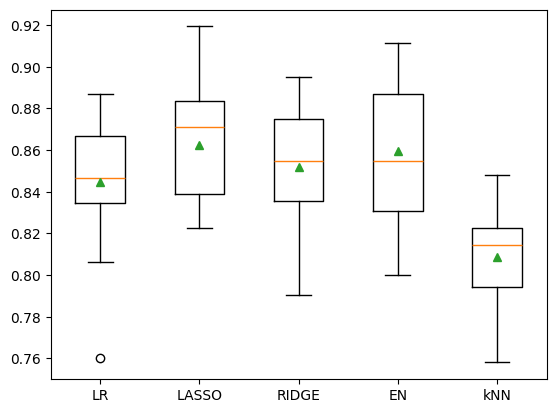

In [87]:
modelos, nombres = mis_modelos()
resultados = list()

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])

  cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=8)

  scores = cross_val_score(pipeline, Xtv, np.ravel(ytv), scoring='accuracy', cv=cv1)

  resultados.append(scores)
  print('>> %s %.3f (%.3f)' % (nombres[i], np.nanmean(scores), np.nanstd(scores)))


plt.boxplot(resultados, labels=nombres, showmeans=True)
plt.show()

### **Seleccionando los mejores valores de los hiperparámetros del mejor modelo**

Una vez seleccionado nuestro mejor modelo podemos hacer una búsqueda más detallada en sus hiperparámetros mediante llamada búsqueda de malla (grid search), como se muestra a continuación.

Recuerda revisar la documentación correspondiente:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html



Observa que GridSearchCV() además de la búsqueda de los mejores valores de los hiperparámetros también incluye Validación Cruzada (Cross-Validation). Esto permite obtener un resultado más robusto en cuanto a los mejores hiperparámetros encontrados.

In [88]:
# Seleccionamos Lasso - métrica L1 como nuestro mejor modelo.
# Observa que los mejores valores dependen de la métrica utilizada.

modelo = LogisticRegression(penalty='l1', max_iter=2000, random_state=1)        # tarda unos 40 segs

dicc_grid = {'C':[ 0.5, 1., 3.],
             'solver':['liblinear','saga']
             }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=8)

grid = GridSearchCV(estimator=modelo,
                    param_grid=dicc_grid,
                    cv=cv,
                    scoring='recall',  # podemos seleccionar otras métricas: 'accuracy', 'f1', 'precision', 'recall'
                    n_jobs=-1,
                    return_train_score=True    # podemos obtener los de entrenamiento para verificar sobreentrenamiento.
                    )


Xx = columnasTransformer.fit_transform(Xtv)

grid_result = grid.fit(Xx, np.ravel(ytv))

print("Mejor valor de la métrica: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaco

Mejor valor de la métrica: 0.901017 usando {'C': 0.5, 'solver': 'liblinear'}


/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaco

In [89]:
grid_result.cv_results_

{'mean_fit_time': array([0.01061266, 0.21396289, 0.01612706, 0.36242615, 0.02973709,
        0.30968396]),
 'std_fit_time': array([0.00497014, 0.04975818, 0.00731053, 0.06336865, 0.01598694,
        0.03734175]),
 'mean_score_time': array([0.00101326, 0.0017156 , 0.00126252, 0.00113463, 0.00103974,
        0.0007521 ]),
 'std_score_time': array([0.00037853, 0.00129415, 0.00095389, 0.00070902, 0.00081199,
        0.00024464]),
 'param_C': masked_array(data=[0.5, 0.5, 1.0, 1.0, 3.0, 3.0],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'param_solver': masked_array(data=['liblinear', 'saga', 'liblinear', 'saga', 'liblinear',
                    'saga'],
              mask=[False, False, False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'C': 0.5, 'solver': 'liblinear'},
  {'C': 0.5, 'solver': 'saga'},
  {'C': 1.0, 'solver': 'liblinear'},
  {'C': 1.0, 'solver': 'saga'},
  {'C': 3.0, 'solver': 'li

In [90]:
print('Train mean(std): %.4f(%.4f)' % (grid_result.cv_results_['mean_train_score'].mean(), grid_result.cv_results_['std_train_score'].mean()))
print('Test mean(std): %.4f(%.4f)' % (grid_result.cv_results_['mean_test_score'].mean(), grid_result.cv_results_['std_test_score'].mean()))

Train mean(std): 0.9109(0.0112)
Test mean(std): 0.8915(0.0334)


In [91]:
# Mejor modelo e hiperparámetros:

modelo_mejor = LogisticRegression(penalty='l1',
                                  max_iter=2000,
                                  solver='liblinear',
                                  C=1.,
                                  random_state=1)

Xx = columnasTransformer.fit_transform(Xtv)

mejor_result = modelo_mejor.fit(Xx, np.ravel(ytv))

mejor_result.score(columnasTransformer.transform(Xtest), np.ravel(ytest))

0.8260869565217391

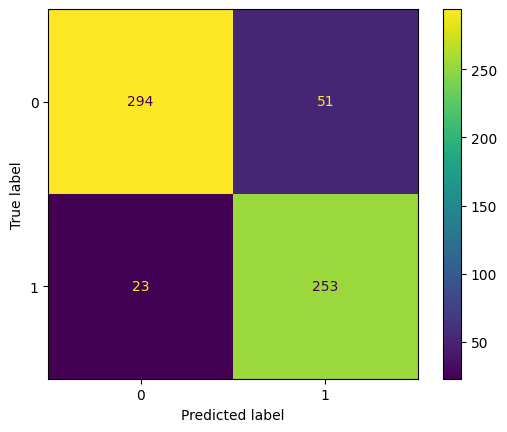

In [92]:
# matriz de confusión:
ConfusionMatrixDisplay.from_estimator(mejor_result, Xx, np.ravel(ytv))
plt.show()

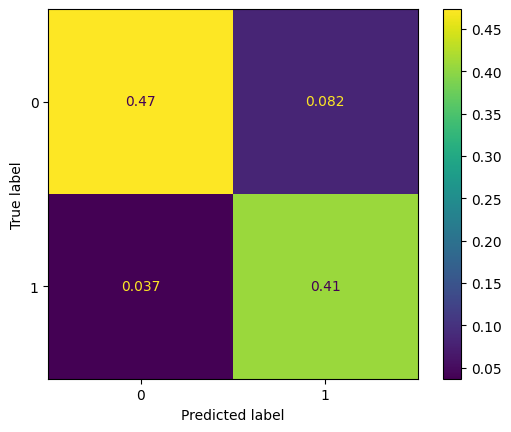

In [93]:
ConfusionMatrixDisplay.from_estimator(mejor_result, Xx, np.ravel(ytv), normalize='all')
plt.show()

In [94]:
# Para obtener los coeficientes más importantes del mejor modelo obtenido:
mejor_result.coef_

array([[ 0.        , -0.08531332,  0.43671733,  0.        , -3.28242548,
         0.        , -0.13034045,  0.73191875,  0.21156759,  0.        ,
         3.57616328,  1.14775932,  0.        ,  0.        ,  0.        ,
         0.35033723,  0.51596064,  0.        ,  0.        ,  0.        ,
        -0.09731747,  0.        , -0.03425919,  0.14901205,  0.        ,
        -0.59470853,  0.        ,  0.        ,  0.0532495 ,  0.        ,
         0.        , -0.19989585, -0.15825114,  0.35488946,  0.        ,
         0.        , -0.30443663,  2.80759095]])

In [95]:
# y para obtenerlo con los nombres de los factores:
pd.DataFrame(data = mejor_result.coef_.reshape(-1,1),
             index = columnasTransformer.get_feature_names_out())

,0
numpipe__A2,0.000000
numpipe__A3,-0.085313
numpipe__A7,0.436717
numpipe__A10,0.000000
numpipe__A13,-3.282425
numpipe__A14,0.000000
catimp__A1,-0.130340
catimp__A4,0.731919
catimp__A5,0.211568
catimp__A6,0.000000
